# Mask R-CNN - Train on Fashion Dataset


This notebook shows how to train Mask R-CNN on Modanet dataset. It is better to have a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from pycocotools.coco import COCO

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [26]:
class FashionConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "fashion"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 13  # background + 13 items

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [27]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [28]:
import io
import lmdb
import sqlite3
import pandas as pd
import json
from PIL import Image
from IPython.display import display

In [29]:
class PhotoData(object):
    def __init__(self, path):
        self.env = lmdb.open(
            path, map_size=2**36, readonly=True, lock=False
        )
        
    def __iter__(self):
        with self.env.begin() as t:
            with t.cursor() as c:
                for key, value in c:
                    yield key, value
        
    def __getitem__(self, index):
        key = str(index).encode('ascii')
        with self.env.begin() as t:
            data = t.get(key)
        if not data:
            return None
        with io.BytesIO(data) as f:
            image = Image.open(f)
            image.load()
            return image
        
    def __len__(self):
        return self.env.stat()['entries']

photo_data = PhotoData(r'..'+os.path.sep+'..'+os.path.sep+'..'+os.path.sep+'photos.lmdb')
print('Number of images from PaperDoll: ', len(photo_data))

Number of images from PaperDoll:  1097474


In [30]:
json_file = r'..' + os.path.sep + '..' + os.path.sep + '..' + os.path.sep + 'modanet2018_instances_train.json'
d = json.load(open(json_file))
print('ModaNet: ', d.keys())
coco=COCO(json_file)
class_ids = sorted(coco.getCatIds())
print(class_ids)
imageIds = coco.getImgIds(catIds=[1])
print('Number of images of bags:', len(imageIds))

ModaNet:  dict_keys(['info', 'images', 'year', 'licenses', 'type', 'annotations', 'categories'])
loading annotations into memory...
Done (t=3.54s)
creating index...
index created!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Number of images of bags: 20570


In [31]:
subset = sorted(coco.getCatIds(catNms=['bag', 'belt', 'outer', 'dress']))
# imageIds = coco.getImgIds(catIds = subset)
ids = []
for id in subset:
    ids.extend(list(coco.getImgIds(catIds=[id])))
    ids = list(set(ids))
print('Number of images of bag, belt , outer, dress:', len(ids))

Number of images of bag, belt , outer, dress: 44168


In [32]:
print('Subset class ids: ', subset)

Subset class ids:  [1, 2, 5, 6]


In [33]:
from pycocotools import mask as maskUtils

class FashionDataset(utils.Dataset):

    def load_fashion(self, count=5, start=0, class_ids=None):
        json_file = r'..' + os.path.sep + '..' + os.path.sep + '..' + os.path.sep + 'modanet2018_instances_train.json'
        d = json.load(open(json_file))
        coco=COCO(json_file)
        
        if not class_ids:
            class_ids = sorted(coco.getCatIds())
        
        if class_ids:
            all_ids = []
            for id in class_ids:
                all_ids.extend(list(coco.getImgIds(catIds=[id])))
            # Remove duplicates
            all_ids = list(set(all_ids))
        else:
            # All images
            all_ids = list(coco.imgs.keys())
        
        # Add classes
        all_class_ids = sorted(coco.getCatIds())
        for i in all_class_ids:
            print('{}:{}'.format(i, coco.loadCats(i)[0]['name']), end='|')
            self.add_class("fashion", i, coco.loadCats(i)[0]['name'])
            
              
        image_ids = []
        for c in range(count):
            image_ids.append(all_ids[c+start])
            
        
        # Add images
        for i in image_ids:
            self.add_image(
                "fashion", image_id=i,
                path=None,
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))
            

    def load_image(self, image_id):
        imgId = self.image_info[image_id]['id']
        image = photo_data[imgId]
        out = np.array(image.getdata()).astype(np.int32).reshape((image.size[1], image.size[0], 3))
        return out
            

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        pass
    

    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = annotation['category_id']
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(FashionDataset, self).load_mask(image_id)
        

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [34]:
subset = sorted(coco.getCatIds(catNms=['bag', 'belt', 'outer', 'dress', 'pants', 'top', 'shorts', 'skirt', 'scarf/tie']))
# Training dataset
train_count = 1
dataset_train = FashionDataset()
dataset_train.load_fashion(train_count, class_ids=subset)
dataset_train.prepare()

# Validation dataset - overfit 1 image
val_count = 1
dataset_val = FashionDataset()
dataset_val.load_fashion(val_count, class_ids=subset)
dataset_val.prepare()

loading annotations into memory...
Done (t=3.98s)
creating index...
index created!
1:bag|2:belt|3:boots|4:footwear|5:outer|6:dress|7:sunglasses|8:pants|9:top|10:shorts|11:skirt|12:headwear|13:scarf/tie|loading annotations into memory...
Done (t=4.88s)
creating index...
index created!
1:bag|2:belt|3:boots|4:footwear|5:outer|6:dress|7:sunglasses|8:pants|9:top|10:shorts|11:skirt|12:headwear|13:scarf/tie|

[ 1  9 10]


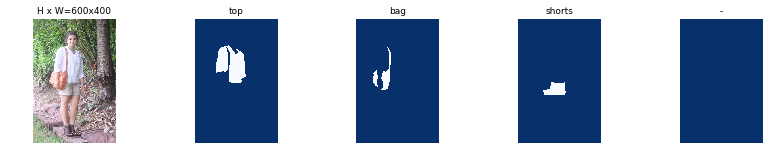

In [35]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## More data samples

In [36]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

loading annotations into memory...
Done (t=3.69s)
creating index...
index created!
1:bag|2:belt|3:boots|4:footwear|5:outer|6:dress|7:sunglasses|8:pants|9:top|10:shorts|11:skirt|12:headwear|13:scarf/tie|

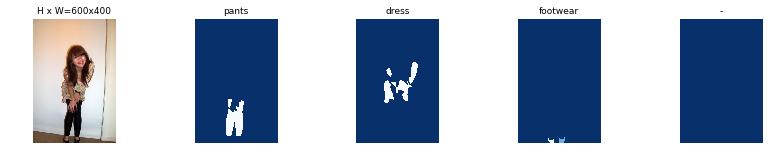

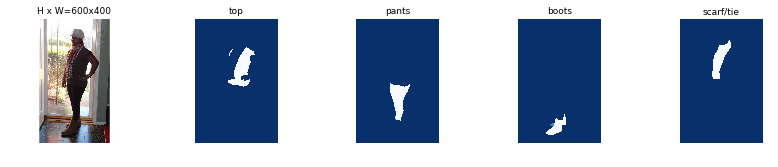

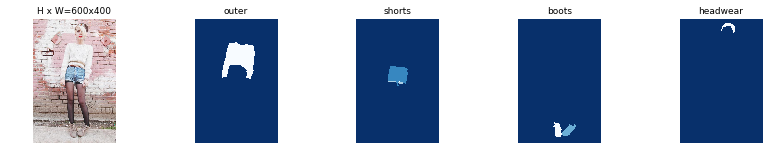

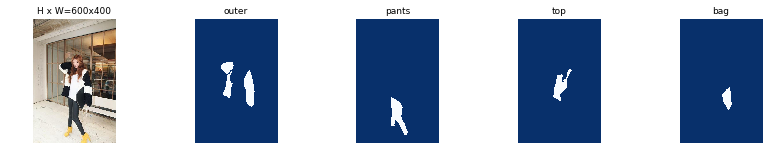

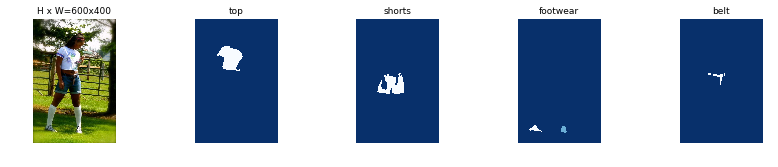

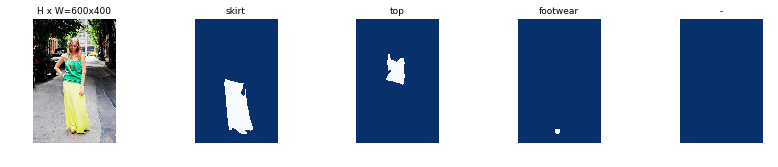

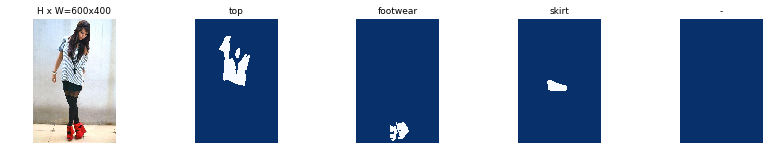

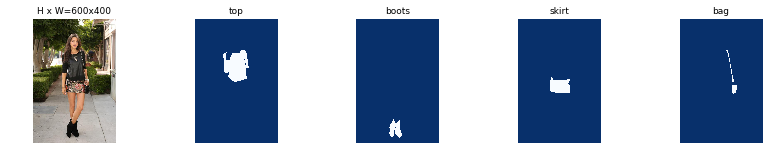

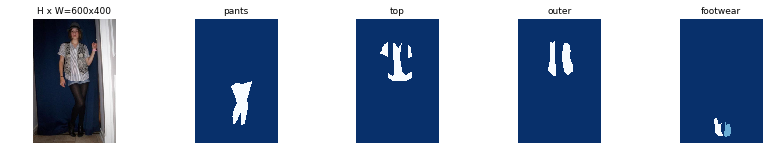

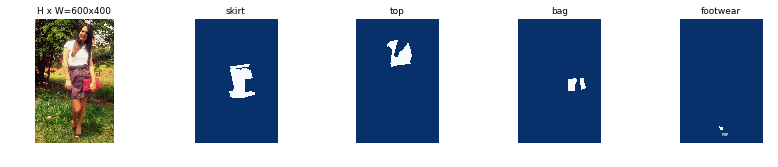

In [37]:
sample_data = FashionDataset()
sample_data.load_fashion(10, start=5)
sample_data.prepare()
for image_id in sample_data.image_ids:
    image = sample_data.load_image(image_id)
    mask, class_ids = sample_data.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, sample_data.class_names)

## Create Model

In [38]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [39]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

### Train Head

In [40]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
history = model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Training\DeepLearningGit\virtualFitting\mask_rcnn\logs\fashion20190527T1740\mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4  

C:\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
100/100 [==============================] - 374s 4s/step - loss: 0.9755 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1852 - mrcnn_mask_loss: 0.4580 - val_loss: 0.3496 - val_rpn_class_loss: 0.0047 - val_rpn_bbox_loss: 0.0066 - val_mrcnn_class_loss: 0.0317 - val_mrcnn_bbox_loss: 0.0888 - val_mrcnn_mask_loss: 0.2179


### Fine Tune all layers

In [41]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
h2 = model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Training\DeepLearningGit\virtualFitting\mask_rcnn\logs\fashion20190527T1740\mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_br

C:\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/2
100/100 [==============================] - 520s 5s/step - loss: 0.3021 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0026 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.2282 - val_loss: 0.2183 - val_rpn_class_loss: 0.0072 - val_rpn_bbox_loss: 2.0151e-04 - val_mrcnn_class_loss: 0.0164 - val_mrcnn_bbox_loss: 0.0043 - val_mrcnn_mask_loss: 0.1902


In [29]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_fashion.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [42]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
inference_config = InferenceConfig()
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  C:\Training\DeepLearningGit\virtualFitting\mask_rcnn\logs\fashion20190527T1740\mask_rcnn_fashion_0002.h5
Re-starting from epoch 2


original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  int32
image_meta               shape: (26,)                 min:    0.00000  max:  600.00000  float64
gt_class_id              shape: (3,)                  min:    1.00000  max:   10.00000  int32
gt_bbox                  shape: (3, 4)                min:   54.00000  max:  157.00000  int32
gt_mask                  shape: (256, 256, 3)         min:    0.00000  max:    1.00000  bool


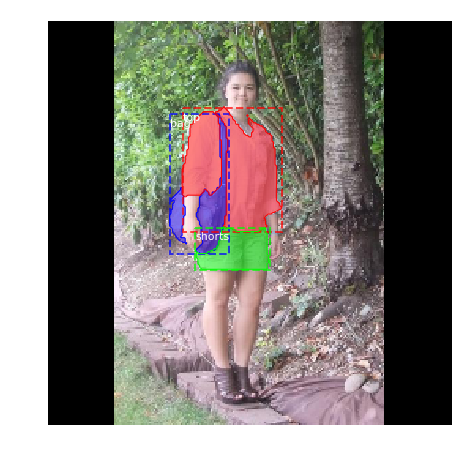

In [43]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
# image_ids = dataset_val.image_ids
image_ids = [0]
for image_id in image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)

    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  int32
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


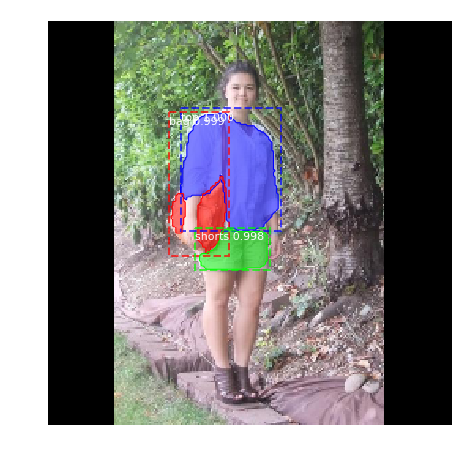

In [44]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [45]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0


## Applications once get the mask
Here is one simple example: if we know the pixel region of the bag and top, we can change the textures or perform any other operations in those regions.

In [49]:
# bag is 1
print(r['masks'].shape, r['class_ids'])
bag = np.where(r['class_ids']==1)
bag_idx = bag[0][0]
mask_bag = r['masks'][:,:,bag_idx]
mask_top = r['masks'][:,:,np.where(r['class_ids']==9)[0][0]]

(256, 256, 3) [ 9  1 10]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


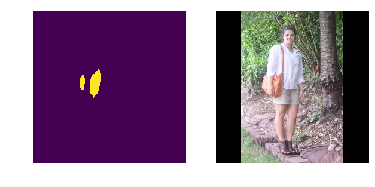

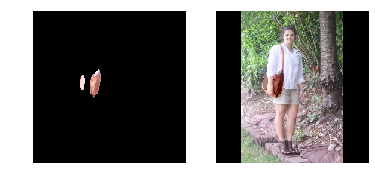

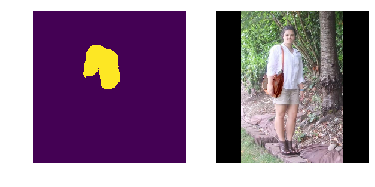

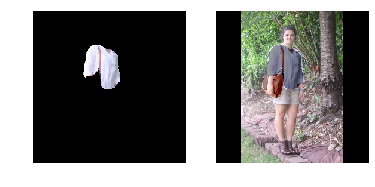

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import numpy as np

image = original_image
out = np.array(image, np.int32)
# mask out skirt
other = out * (mask_bag[:,:,None] == 0)
bag = out * (mask_bag[:,:,None]!=0)
change = (out-90) * (mask_bag[:,:,None]!=0)
mix = other + bag

plt.figure(1)
plt.subplot(1,2,1).axis('off')
plt.imshow(mask_bag)
plt.subplot(1,2,2).axis('off')
plt.imshow(mix)

plt.figure(2)
plt.subplot(1,2,1).axis('off')
plt.imshow(bag)
plt.subplot(1,2,2).axis('off')
plt.imshow(other+change)

out = other + change
other = out * (mask_top[:,:,None] == 0)
top = out * (mask_top[:,:,None]!=0)
change = (out-100) * (mask_top[:,:,None]!=0)
mix = other + top

plt.figure(3)
plt.subplot(1,2,1).axis('off')
plt.imshow(mask_top)
plt.subplot(1,2,2).axis('off')
plt.imshow(mix)

plt.figure(4)
plt.subplot(1,2,1).axis('off')
plt.imshow(top)
plt.subplot(1,2,2).axis('off')
plt.imshow(other+change)